In [1]:
import numpy as np
from numpy import genfromtxt

import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import Utools as utls #modified AnaTools
import Ptools4Jup as ptls

#plt.ion()  #interactive mode on
%matplotlib inline

In [2]:
# Set the path pointing to the data files:
path = '/Users/Yuquan/Documents/SLAC/tutorial/'

In [3]:
%%time

# Read the .dat file and drop the header:
test_data = utls.readBoolMike(path + 'data/test/e1chRNWFs_19.dat')

# Seperate the waveforms and the labels:
x_test,y_test = utls.sepXY(test_data)

# Make a baseline correction:
x_test = utls.baseCorrection(x_test)

# Store the data in a DataSet object:
data_test = utls.DataSet(x_test,y_test)

CPU times: user 21.1 s, sys: 2.04 s, total: 23.1 s
Wall time: 25.3 s


Samlpe Number: 8202
True energy [keV]: 0.0


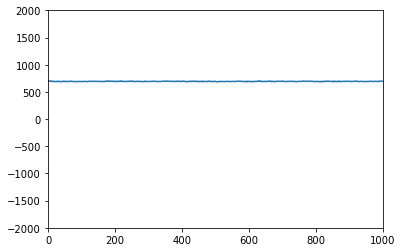

In [4]:
sizeOfSet = data_test.images.shape[0]
sample = np.random.randint(sizeOfSet)

axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([-2000,2000])

print ("Samlpe Number: " + str(sample))
print ("True energy [keV]: " + str(y_test[sample,0]))
fig = plt.plot(x_test[sample])

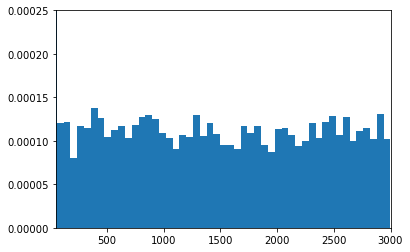

In [5]:
plt.hist(y_test, 50, normed=1)
plt.axis([50, 3000, 0, 0.00025])
plt.show;

In [7]:
%%time

nFiles = 1

train_data = np.empty((0,1001),np.float32)

for i in range(nFiles):
    print("Loading train date: file {0}".format(i))
    train_temp = utls.readBoolMike(path + 'data/train/e1chRNWFs_'+str(i)+'.dat')
    train_data = np.append(train_data,train_temp,axis=0)

x_train,y_train = utls.sepXY(train_data)
x_train = utls.baseCorrection(x_train)
data_train = utls.DataSet(x_train,y_train)

Loading train date: file 0
CPU times: user 18.9 s, sys: 1.4 s, total: 20.3 s
Wall time: 20.9 s


In [8]:
x = tf.placeholder(tf.float32,[None,1000])
y_ = tf.placeholder(tf.float32,[None,1])

# Input layer
W0 = tf.get_variable("W0",shape=[1000,500],initializer=tf.contrib.layers.xavier_initializer())
b0 = utls.bias_var([500])
h0 = tf.nn.relu(tf.matmul(x,W0)+b0)

keep_prob = tf.placeholder(tf.float32)
h0_drop = tf.nn.dropout(h0,keep_prob)

# Hidden layer 1
W1 = tf.get_variable("W1",shape=[500,100],initializer=tf.contrib.layers.xavier_initializer())
b1 = utls.bias_var([100])
h1 = tf.nn.relu(tf.matmul(h0_drop,W1)+b1)

# Hidden layer 2
#W2 = tf.get_variable("W2",shape=[200,100],initializer=tf.contrib.layers.xavier_initializer())
#b2 = utls.bias_var([100])
#h2 = tf.nn.relu(tf.matmul(h1,W2)+b2)

# Hidden layer 3
#W3 = tf.get_variable("W3",shape=[100,40],initializer=tf.contrib.layers.xavier_initializer())
#b3 = utls.bias_var([40])
#h3 = tf.nn.relu(tf.matmul(h2,W3)+b3)

# Hidden layer 4
#W4 = tf.get_variable("W4",shape=[40,10],initializer=tf.contrib.layers.xavier_initializer())
#b4 = utls.bias_var([10])
#h4 = tf.nn.relu(tf.matmul(h3,W4)+b4)

# Hidden layer 5
W5 = tf.get_variable("W5",shape=[100,2],initializer=tf.contrib.layers.xavier_initializer())
b5 = utls.bias_var([2])
h5 = tf.nn.relu(tf.matmul(h1,W5)+b5)

# Output layer
W_last = tf.get_variable("W_last",shape=[2,1],initializer=tf.contrib.layers.xavier_initializer())
b_last = utls.bias_var([1])
y = tf.nn.relu(tf.matmul(h5,W_last)+b_last)

In [9]:
mse = tf.reduce_mean(tf.square(y-y_))

#regularizers = (tf.nn.l2_loss(W0)+tf.nn.l2_loss(b0)+tf.nn.l2_loss(W1)+tf.nn.l2_loss(b1)+
#tf.nn.l2_loss(W2)+tf.nn.l2_loss(b2)+tf.nn.l2_loss(W3)+tf.nn.l2_loss(b3)+
#tf.nn.l2_loss(W4)+tf.nn.l2_loss(b4)+tf.nn.l2_loss(W5)+tf.nn.l2_loss(b5)+
#tf.nn.l2_loss(W_last)+tf.nn.l2_loss(b_last))

regularizers = (tf.nn.l2_loss(W0)+tf.nn.l2_loss(b0)+tf.nn.l2_loss(W1)+tf.nn.l2_loss(b1)
+tf.nn.l2_loss(W5)+tf.nn.l2_loss(b5)+tf.nn.l2_loss(W_last)+tf.nn.l2_loss(b_last))



loss = mse + regularizers*1.e-4

In [10]:
# the optimizer itself:
opt = tf.train.AdamOptimizer()

# the vanilla operation trains the whole network
opt_operation = opt.minimize(loss)

# this allows to train a layer individualy
opt_operation_0 = opt.minimize(loss, var_list=[W0,b0])
opt_operation_1 = opt.minimize(loss, var_list=[W1,b1])
#opt_operation_2 = opt.minimize(loss, var_list=[W2,b2])
#opt_operation_3 = opt.minimize(loss, var_list=[W3,b3])
#opt_operation_4 = opt.minimize(loss, var_list=[W4,b4])
opt_operation_5 = opt.minimize(loss, var_list=[W5,b5])
opt_operation_last = opt.minimize(loss, var_list=[W_last,b_last])

In [11]:
saver = tf.train.Saver()

In [12]:
# start a TensorFlow session:
with tf.Session() as sess:
    
    # random initialization:
    sess.run(tf.global_variables_initializer())
    
    # save the weights in a file
    save_path = saver.save(sess, path + "check-points/start.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: /Users/Yuquan/Documents/SLAC/tutorial/check-points/start.ckpt


In [14]:
# start a TensorFlow session:
with tf.Session() as sess:
    Q_good_start = 0
    
    # this loop selects a reasonable starting point and saves it in "start.ckpt"
    while Q_good_start == 0:
        sess.run(tf.global_variables_initializer())
        save_path = saver.save(sess, path + "check-points/start.ckpt")
        
        # this loop takes the random initialization and trains the net for 100 steps to see if it learns.
        for i in range(100):
            batch = data_train.next_batch(500)
            sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # test if the net learned
        tce = mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.0},session=sess)
        print("test mse %g"%(tce))
            
        if tce < 800000:
            Q_good_start = 1
            print("Yay! Start saved in file: %s" % save_path)

test mse 992407
test mse 984399
test mse 983404
test mse 965330
test mse 776423
Yay! Start saved in file: /Users/Yuquan/Documents/SLAC/tutorial/check-points/start.ckpt


In [16]:
%%time

# define how to train this training cycle
batchSize = 500
trainSteps = 1000

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "check-points/start.ckpt")
    
    # the train cycle
    for i in range(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%1000 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 1 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle1-end.ckpt")

INFO:tensorflow:Restoring parameters from /Users/Yuquan/Documents/SLAC/tutorial/check-points/start.ckpt
step 0
Train cycle 1 ended with a test accuracy of: 978508.56
CPU times: user 2min 44s, sys: 10.7 s, total: 2min 55s
Wall time: 1min 4s


INFO:tensorflow:Restoring parameters from /Users/Yuquan/Documents/SLAC/tutorial/check-points/start.ckpt
Code reached iterration: 0 with a train mse of 13064179.0
Code reached iterration: 1000 with a train mse of 980183.3125
Code reached iterration: 2000 with a train mse of 987858.625
Code reached iterration: 3000 with a train mse of 987325.3125
Code reached iterration: 4000 with a train mse of 985948.0625
Train cycle 1 ended with a test accuracy of: 984023.56


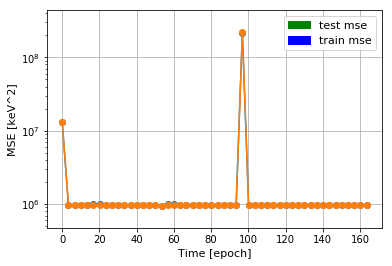

CPU times: user 16min 45s, sys: 1min 3s, total: 17min 48s
Wall time: 6min 51s


In [18]:
%%time
sizeOfSet = data_train.images.shape[0]
train_time = []
i=0
trainloss = []
testloss = []
cycleID = 1

# define how to train this training cycle
batchSize = 500
trainSteps = 5000

# start a TensorFlow session:

with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "check-points/start.ckpt")

    # the train cycle
    for j in range(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # count how many samples were used to train
        i += batchSize
        
        # every now and then save the weights and print some stuff
        if j%100 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            
            train_mse = mse.eval(feed_dict={x:data_train.images,y_:data_train.labels,keep_prob:1.0},session=sess)
            trainloss.append(train_mse)
            test_mse = mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.0},session=sess)
            testloss.append(test_mse)
            train_time.append(float(i)/sizeOfSet)

            if j%1000 == 0:
                # ploting output:
                ptls.PrintInfo(j,test_mse)
        
    # end this train cycle
    print("Train cycle 1 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle1-end.ckpt")
    
    # learning rate plot
    ptls.MSEHist(cycleID,trainloss,testloss,train_time)

In [20]:
# define how to train this training cycle
batchSize = 1000
trainSteps = 1000
opt = tf.train.AdamOptimizer(1.0e-4)

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "check-points/cycle1-end.ckpt")
    
    # the train cycle
    for i in range(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%100 == 0:
            save_path = saver.save(sess, "temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 2 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, "cycle2-end.ckpt")

INFO:tensorflow:Restoring parameters from /Users/Yuquan/Documents/SLAC/tutorial/check-points/cycle1-end.ckpt
step 0
step 100
step 200
step 300
step 400
step 500
step 600
step 700
step 800
step 900
Train cycle 2 ended with a test accuracy of: 986969.19


In [ ]:
Not fin

In [22]:
# define how to train this training cycle
batchSize = 5000
trainSteps = 10000
opt = tf.train.AdamOptimizer(1.0e-5)

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "cycle2-end.ckpt")
    
    # the train cycle
    for i in range(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%1000 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 3 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle3-end.ckpt")

INFO:tensorflow:Restoring parameters from /Users/Yuquan/Documents/SLAC/tutorial/cycle2-end.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /Users/Yuquan/Documents/SLAC/tutorial/cycle2-end.ckpt
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]

Caused by op 'save/RestoreV2_1', defined at:
  File "/Users/Yuquan/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Yuquan/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-18da33d742f9>", line 1, in <module>
    saver = tf.train.Saver()
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1140, in __init__
    self.build()
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1172, in build
    filename=self._filename)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 688, in build
    restore_sequentially, reshape)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 663, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Yuquan/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /Users/Yuquan/Documents/SLAC/tutorial/cycle2-end.ckpt
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]


In [ ]:
# define how to train this training cycle
batchSize = 15000
trainSteps = 100000
opt = tf.train.AdamOptimizer(1.0e-6)

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + path + "check-points/cycle3-end.ckpt")
    
    # the train cycle
    for i in xrange(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%1000 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 4 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle4-end.ckpt")